In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
from tensorflow.linalg import matmul
import keras
import matplotlib.pyplot as plt
from matplotlib import pyplot

from rbm_utils import forward_pass, backward_pass

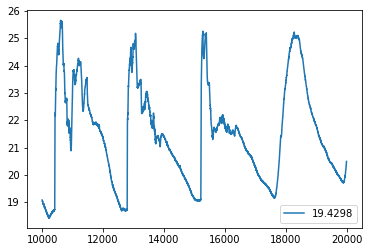

In [ ]:
temperature = pd.read_csv('temperature.txt', sep = " ", lineterminator='\n')
# temperature.describe()
split_it = temperature[10000:20000]

# temperature.isna()
split_it.plot()
plt.show()

In [ ]:
"""Implementation of a Restricted Boltzmann Machine"""

class RBM():
    """Implementation of a Restricted Boltzmann Machine
    
    Note that this implementation does not use Pytorch's nn.Module
    because we are updating the weights ourselves

    """
    def __init__(self, visible_dim, hidden_dim, gaussian_hidden_distribution=False):
        """Initialize a Restricted Boltzmann Machine

        Parameters
        ----------
        visible_dim: int
            number of dimensions in visible (input) layer
        hidden_dim: int
            number of dimensions in hidden layer
        gaussian_hidden_distribution: bool
            whether to use a Gaussian distribution for the values of the hidden dimension instead of a Bernoulli
    
        """
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.gaussian_hidden_distribution = gaussian_hidden_distribution

        # intialize parameters
        x = tf.random.truncated_normal((visible_dim, hidden_dim), mean=0.0, stddev=0.05, seed=None)
        self.W = tf.Variable(x)
        self.h_bias = tf.zeros(hidden_dim)  # v --> h
        self.v_bias = tf.zeros(visible_dim)  # h --> v

        # parameters for learning with momentum
        self.W_momentum = tf.zeros((visible_dim, hidden_dim))
        self.h_bias_momentum = tf.zeros(hidden_dim)  # v --> h
        self.v_bias_momentum = tf.zeros(visible_dim)  # h --> v

    def sample_h(self, v):
        """Get sample hidden values and activation probabilities

        Parameters
        ----------
        v: Tensor
            tensor of input from visible layer

        """
        activation = forward_pass(v, self.W) + self.h_bias
        if self.gaussian_hidden_distribution:
            return activation, tf.random.normal(activation.shape, mean=activation)
        else:
            p = tf.sigmoid(activation)
            samples = tfp.distributions.Bernoulli(probs=p).sample(sample_shape=())
            return p, tf.cast(samples, tf.float32)

    def sample_v(self, h):
        """Get visible activation probabilities

        Parameters
        ----------
        h: Tensor
            tensor of input from hidden

        """
        activations = backward_pass(h, self.W) 
        activation = activations.read(0) + self.v_bias
        p = tf.sigmoid(activation)
        return p

    def update_weights(self, v0, vk, ph0, phk, lr, momentum_coef, weight_decay, batch_size):
        """Learning step: update parameters 

        Uses contrastive divergence algorithm as described in

        Parameters
        ----------
        v0: Tensor
            initial visible state
        vk: Tensor
            final visible state
        ph0: Tensor
            hidden activation probabilities for v0
        phk: Tensor
            hidden activation probabilities for vk
        lr: float
            learning rate
        momentum_coef: float
            coefficient to use for momentum
        weight_decay: float
            coefficient to use for weight decay
        batch_size: int
            size of each batch

        """
        self.W_momentum *= momentum_coef
        self.W_momentum = tf.cast(self.W_momentum, tf.float32)
        # self.W_momentum = tf.expand_dims(self.W_momentum, axis=1)
        self.W_momentum = self.W_momentum + matmul(tf.transpose(v0), ph0) - matmul(tf.transpose(vk), phk)
        self.h_bias_momentum *= momentum_coef
        self.h_bias_momentum += tf.math.reduce_sum((ph0 - phk), 0)

        self.v_bias_momentum *= momentum_coef
        self.v_bias_momentum += tf.math.reduce_sum((v0 - vk), 0)

        self.W = self.W + lr*self.W_momentum/batch_size
        self.h_bias += lr*self.h_bias_momentum/batch_size
        self.v_bias += lr*self.v_bias_momentum/batch_size

        self.W -= self.W * weight_decay # L2 weight decay


In [ ]:
# dim_v = 4
# dim_h = 2
# rbm = RBM(dim_v, dim_h, gaussian_hidden_distribution=True)
# rbm.W

In [ ]:
# v0 = tf.random.truncated_normal((1, dim_v))
# probs, outputs = rbm.sample_h(v0)
# outputs

In [ ]:
# rbm.sample_v(outputs)

In [ ]:
# sample_data = tf.constant([[5,3,1,2]], dtype=tf.float32)

# v0, pvk = sample_data, sample_data

# k = 1
# lr = 0.1
# epoch = 100


# # Gibbs sampling
# for i in range(k):
#     _, hk = rbm.sample_h(pvk)
#     pvk = rbm.sample_v(hk)

# # compute ph0 and phk for updating weights
# ph0, _ = rbm.sample_h(v0)
# phk, _ = rbm.sample_h(pvk)

# # update weights
# rbm.update_weights(v0, pvk, ph0, phk, lr, 
#                     momentum_coef=0.5 if epoch < 5 else 0.9, 
#                     weight_decay=2e-4, 
#                     batch_size=1)

In [ ]:
def min_max_scale_data(data):
    mean = np.mean(data)
    scaling_ratio = np.max(data) - np.min(data)
    scaled_data = (data - mean) / scaling_ratio

    return scaled_data, mean, scaling_ratio

def unscale_min_maxed_data(scaled_data, mean, scaling_ratio):
    return scaled_data * scaling_ratio + mean


vals = min_max_scale_data(temperature)
recreated = unscale_min_maxed_data(*vals)

In [ ]:
temperature = pd.read_csv('temperature.txt', sep = " ", lineterminator='\n')
temperature = temperature[10000:20000]
unscaled_temp = temperature.to_numpy()
temperature = temperature.to_numpy()
temperature, mean, scaling_ratio = min_max_scale_data(temperature)
temperature = np.array_split(temperature, 100)
unscaled_temp = np.array_split(unscaled_temp, 100)

In [ ]:
num_epochs = 30
k = 1
dim_v = 100
dim_h = 75
lr = 0.001
rbm = RBM(dim_v, dim_h, gaussian_hidden_distribution=True)
rbm.W.shape

TensorShape([100, 75])

In [ ]:
def loss(reconstruction, label):
    return np.mean(((reconstruction - label)**2))

In [ ]:
def train_rbm():
    losses = []
    for epoch in range(num_epochs):
        train_loss = 0
        # output = []
        for sequence in temperature:
            sequence = tf.constant(sequence.T, dtype=tf.float32)
            sample_data = sequence
            v0, pvk = sample_data, sample_data

            # Gibbs sampling
            for i in range(k):
                _, hk = rbm.sample_h(pvk)
                # print(hk)
                # print('----------')
                pvk = rbm.sample_v(hk)
            # Sample from the distribution of the visible layer -> the data
            
            # compute ph0 and phk for updating weights
            ph0, _ = rbm.sample_h(v0)
            phk, _ = rbm.sample_h(pvk)
            # print(phk)
            
            # update weights
            rbm.update_weights(v0, pvk, ph0, phk, lr, 
                                # momentum_coef=0.5 if epoch < 5 else 0.9,
                                momentum_coef = 0.1,
                                weight_decay=2e-4, 
                                batch_size=1)

            # track loss
            train_loss += loss(v0, pvk)

        #     #add output
        #     output_per_epoch = unscale_min_maxed_data(pvk, mean, scaling_ratio)
        # output.append(output_per_epoch)
        losses.append(train_loss)
        print(f"epoch {epoch}: {train_loss}")
    return rbm, v0, pvk, losses

In [ ]:
rbm, v0, pvk, losses = train_rbm()

epoch 0: 31.09093051496893
epoch 1: 29.977392532862723
epoch 2: 28.71958818892017
epoch 3: 27.540628700517118
epoch 4: 26.377609560266137
epoch 5: 25.350355052854866
epoch 6: 24.345556759275496
epoch 7: 23.386035518255085
epoch 8: 22.432883630506694
epoch 9: 21.566476794425398
epoch 10: 20.66372764017433
epoch 11: 19.833904223050922
epoch 12: 19.04769315966405
epoch 13: 18.128559853881598
epoch 14: 17.397427041549236
epoch 15: 16.479279460618272
epoch 16: 15.448714529396966
epoch 17: 14.237375864293426
epoch 18: 12.375386885367334
epoch 19: 10.663183088414371
epoch 20: 8.495136321056634
epoch 21: 6.788939125370234
epoch 22: 6.110646187327802
epoch 23: 5.347125384025276
epoch 24: 5.244229813339189
epoch 25: 4.887404344277456
epoch 26: 4.659885450266302
epoch 27: 4.699216232373146
epoch 28: 4.557414547831286
epoch 29: 4.609119403670775


## Upscaling the data

In [ ]:
output = unscale_min_maxed_data(pvk, mean, scaling_ratio)

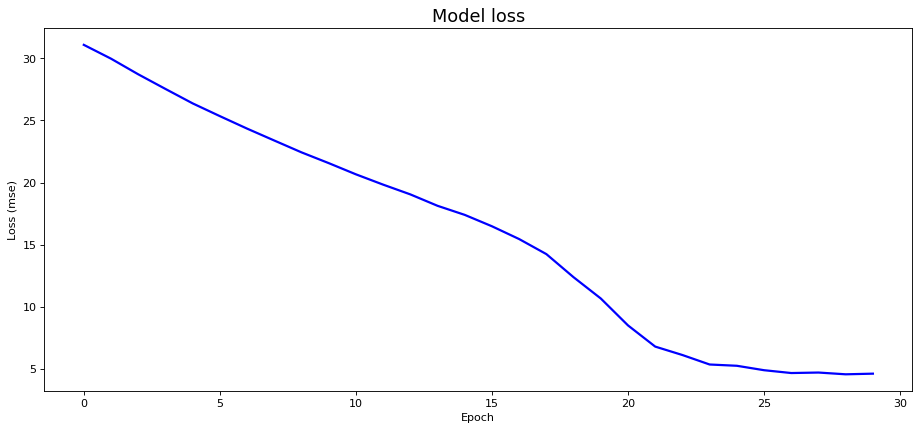

In [ ]:
fig, ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(losses, 'b', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mse)')
ax.set_xlabel('Epoch')
# ax.legend(loc='upper right')
plt.show()

In [ ]:
# img = make_grid(v0.view(v0.shape[0], 1, dim1, dim2).data)
# npimg = np.transpose(img.detach().cpu().numpy(), (1, 2, 0))
# plt.imshow(npimg)
# if v0_fname is not None:
#     plt.savefig(v0_fname)
# plt.show()
# img = make_grid(vk.view(vk.shape[0], 1, dim1, dim2).data)
# npimg = np.transpose(img.detach().cpu().numpy(), (1, 2, 0))
# plt.imshow(npimg)
# if vk_fname is not None:
#     plt.savefig(vk_fname)    
# plt.show()

In [ ]:
rbm

In [ ]:
# 1. Loop through all the sequences (splittet arrays from temp.txt)
# 2. Add every loop to the predicitons array !Temperature array is not scaled back - only the outputs array, which is only for the last batch.
# 3. compare predictions to the original temperature array

In [ ]:
def predict_with_trained_weights(data, rbm):
    
    predictions = []

    for sequence in data:
        sequence = tf.constant(sequence.T, dtype=tf.float32)
        _, sequence_predictions = rbm.sample_h(sequence)
        sequence_predictions = rbm.sample_v(sequence_predictions)
        predictions.append(sequence_predictions)

    diff = 0

    for label, prediction in zip(unscaled_temp, predictions):
        unscaled_predictions = unscale_min_maxed_data(prediction, mean, scaling_ratio)
        diff += np.mean(unscaled_predictions - label)
    
    return predictions, diff

In [ ]:
preds = predict_with_trained_weights(temperature, rbm)

In [ ]:
preds

([<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
  array([[0.00276536, 0.00293657, 0.00197685, 0.0017893 , 0.00223053,
          0.00211078, 0.00176966, 0.00214428, 0.00242269, 0.00188914,
          0.00252873, 0.00202271, 0.00294486, 0.00147817, 0.00150195,
          0.00204703, 0.00175396, 0.00215212, 0.00150535, 0.00245777,
          0.00162834, 0.00195205, 0.00330609, 0.00151414, 0.00167716,
          0.00115368, 0.0011844 , 0.00189501, 0.00184119, 0.00118437,
          0.00152704, 0.0015693 , 0.00135639, 0.00238648, 0.00208011,
          0.00225547, 0.00208598, 0.00141978, 0.00190836, 0.00157744,
          0.0019193 , 0.00138104, 0.00160435, 0.00149593, 0.00121421,
          0.00123522, 0.0018653 , 0.00107682, 0.00198069, 0.00138113,
          0.00126451, 0.00190005, 0.00126401, 0.00176424, 0.00135368,
          0.00144571, 0.00110787, 0.00124878, 0.00146642, 0.00108451,
          0.00114998, 0.00119358, 0.00132501, 0.00120243, 0.00090036,
          0.00127158, 0.00116616, 0.00

In [ ]:
unscaled_temp

[array([[19.077 ],
        [19.0672],
        [19.0672],
        [19.0476],
        [19.0378],
        [19.028 ],
        [19.0476],
        [19.0378],
        [19.028 ],
        [19.028 ],
        [19.0378],
        [19.028 ],
        [19.028 ],
        [19.028 ],
        [19.0378],
        [19.0084],
        [19.0084],
        [19.028 ],
        [19.0084],
        [18.9986],
        [19.0084],
        [18.9888],
        [18.979 ],
        [18.9692],
        [18.9398],
        [18.9398],
        [18.9496],
        [18.9496],
        [18.9398],
        [18.9398],
        [18.93  ],
        [18.9398],
        [18.93  ],
        [18.93  ],
        [18.9202],
        [18.93  ],
        [18.9398],
        [18.9496],
        [18.93  ],
        [18.93  ],
        [18.93  ],
        [18.93  ],
        [18.93  ],
        [18.9398],
        [18.93  ],
        [18.93  ],
        [18.93  ],
        [18.9398],
        [18.93  ],
        [18.9202],
        [18.93  ],
        [18.9104],
        [18.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=173b32cc-971d-47dd-bf0a-1dc64f9109d1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>